In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Optimizer SGD

# Configuration du matériel et des hyperparamètres
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epsilon = 0.25  # Perturbation de 0.25 (valeur spécifique au papier Goodfellow et al. pour MNIST)

# 1. Définition de la couche Maxout (non native dans PyTorch)
# Le Maxout est une fonction d'activation apprenable.
# Contrairement à une couche dense standard f(x) = Act(Wx+b),
# Maxout calcule k fonctions affines et retourne le maximum : h_i(x) = max_{j \in [1,k]} z_{ij}
class Maxout(nn.Module):
    def __init__(self, d_in, d_out, pool_size):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.pool_size = pool_size # Correspond au 'k' (nombre de morceaux linéaires)
        # Une seule couche linéaire calcule l'ensemble des k * d_out features
        self.lin = nn.Linear(d_in, d_out * pool_size)

    def forward(self, x):
        # Redimensionnement pour séparer les 'k' features maps
        # Entrée : [Batch, d_in] -> Sortie Linéaire : [Batch, d_out * k]
        shape = list(x.size())
        shape[-1] = self.d_out
        shape.append(self.pool_size)
        
        # On redimensionne en [Batch, d_out, k] et on applique le max sur la dernière dimension (k)
        # Cela génère la non-linéarité convexe par morceaux.
        max_output, _ = self.lin(x).view(*shape).max(-1)
        return max_output

# Architecture du réseau Maxout
# Structure dense standard pour MNIST, utilisant 240 unités et k=5 comme décrit dans la littérature.
class MaxoutNet(nn.Module):
    def __init__(self):
        super(MaxoutNet, self).__init__()
        # Topologie : 784 (Input) -> 240 (Maxout) -> 240 (Maxout) -> 10 (Linear/Softmax)
        self.fc1 = Maxout(784, 240, 5) 
        self.fc2 = Maxout(240, 240, 5)
        self.fc3 = nn.Linear(240, 10) # Projection finale vers les logits des 10 classes

    def forward(self, x):
        x = x.view(-1, 784) # Aplatissement des images 28x28
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Instanciation du modèle et de la fonction de coût
model = MaxoutNet().to(device)
criterion = nn.CrossEntropyLoss()

# Optimiseur SGD avec Momentum (Configuration standard pour éviter les minimums locaux)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epoch = 5

# 2. Préparation des Dataloaders et Entraînement
print("Entraînement du réseau Maxout...")
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=transforms.ToTensor()),
    batch_size=1, shuffle=True) # Batch size de 1 pour faciliter la génération d'attaque par image

model.train()
for i in range(1, epoch+1):
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad() # Réinitialisation des gradients accumulés
        output = model(data)
        loss = criterion(output, target)
        loss.backward() # Rétropropagation
        optimizer.step() # Mise à jour des poids
    print(f"Loss pour l'epoch {i}/{epoch} : {loss}")    
print("Entraînement terminé.")

# Implémentation de l'attaque FGSM (Fast Gradient Sign Method)
# Formule : x_adv = x + epsilon * sign(gradient_x(J(theta, x, y)))
def fgsm_attack(model, data, target, epsilon):
    # On clone les données pour ne pas modifier le dataset original
    data = data.clone().detach().to(device)
    # Important : On demande le gradient par rapport à l'INPUT (pixels), pas les poids
    data.requires_grad = True
    target = target.to(device)

    output = model(data)
    loss = criterion(output, target)

    model.zero_grad()
    loss.backward()

    # Récupération du signe du gradient de la perte par rapport à l'entrée
    data_grad = data.grad.data
    
    # Création de la perturbation
    perturbed_data = data + epsilon * data_grad.sign()
    
    # Projection (clamping) pour garantir que l'image reste dans l'espace valide [0, 1]
    perturbed_data = torch.clamp(perturbed_data, 0, 1)

    return perturbed_data

# Procédure d'évaluation
# Permet de tester la précision sur données propres ou adverses
def evaluate(model, dataloader, adversarial=False):
    correct = 0
    total = 0
    model.eval()

    for data, target in dataloader:
        data, target = data.to(device), target.to(device)

        if adversarial:
            # Génération de l'exemple adverse à la volée
            data = fgsm_attack(model, data, target, epsilon)
            output = model(data)
        else:
            # Sur données propres, on désactive le calcul de gradient pour économiser la mémoire
            with torch.no_grad():
                output = model(data)

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    return 100. * correct / total

def mean_confidence_on_errors(model, dataloader, adversarial=False):
    """Calcule la confiance moyenne (softmax) spécifiquement sur les erreurs de classification.
       Cela permet de vérifier si le modèle est 'trop confiant' même quand il se trompe."""
    model.eval()
    confidences = []

    for data, target in dataloader:
        data, target = data.to(device), target.to(device)

        if adversarial:
            data = fgsm_attack(model, data, target, epsilon)
            output = model(data)
        else:
            with torch.no_grad():
                output = model(data)

        probs = torch.softmax(output, dim=1)
        preds = probs.argmax(dim=1)

        # Filtrage : On ne garde que les prédictions incorrectes
        mask = preds != target
        if mask.any():
            conf = probs[mask, preds[mask]]
            confidences.extend(conf.detach().cpu().tolist())

    if len(confidences) == 0:
        return 0.0

    return sum(confidences) / len(confidences)


# Résultats et Affichage
acc_test_clean = evaluate(model, test_loader, adversarial=False)
conf_test_clean = mean_confidence_on_errors(model, test_loader, adversarial=False)
acc_test_adv   = evaluate(model, test_loader, adversarial=True)
conf_test_adv   = mean_confidence_on_errors(model, test_loader, adversarial=True)
acc_train_adv  = evaluate(model, train_loader, adversarial=True)
conf_train_adv  = mean_confidence_on_errors(model, train_loader, adversarial=True)

print("--- Résultats Maxout Network ---")
print(f"Accuracy Test Clean   : {acc_test_clean:.2f}%")
print(f"Confiance moyenne erreurs Test Clean : {conf_test_clean:.4f}")
print(f"Accuracy Test FGSM    : {acc_test_adv:.2f}%")
print(f"Confiance moyenne erreurs Test FGSM  : {conf_test_adv:.4f}")
print(f"Accuracy Train FGSM   : {acc_train_adv:.2f}%")
print(f"Confiance moyenne erreurs Train FGSM : {conf_train_adv:.4f}")

Entraînement du réseau Maxout...
Loss pour l'epoch 1/5 : 0.17560359835624695
Loss pour l'epoch 2/5 : 0.11376257240772247
Loss pour l'epoch 3/5 : 0.01981145702302456
Loss pour l'epoch 4/5 : 0.02226344123482704
Loss pour l'epoch 5/5 : 0.01986103132367134
Entraînement terminé.
--- Résultats Maxout Network ---
Accuracy Test Clean   : 97.76%
Confiance moyenne erreurs Test Clean : 0.7299
Accuracy Test FGSM    : 0.67%
Confiance moyenne erreurs Test FGSM  : 0.8989
Accuracy Train FGSM   : 0.44%
Confiance moyenne erreurs Train FGSM : 0.8922


In [8]:
# Optimizer Adam

# Configuration de l'environnement d'exécution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epsilon = 0.25  # Facteur de perturbation (identique à l'expérience SGD)

# 1. Définition de l'architecture Maxout
# Rappel : Maxout est une unité d'activation convexe par morceaux (Piecewise Linear).
# Elle permet d'approximer arbitrairement bien toute fonction convexe.
class Maxout(nn.Module):
    def __init__(self, d_in, d_out, pool_size):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.pool_size = pool_size
        # Une seule transformation linéaire gère l'ensemble des k (pool_size) filtres affines
        self.lin = nn.Linear(d_in, d_out * pool_size)

    def forward(self, x):
        # Redimensionnement : [Batch, Input] -> [Batch, Output, Pool_Size]
        shape = list(x.size())
        shape[-1] = self.d_out
        shape.append(self.pool_size)
        # Opération de pooling : Sélection de la valeur maximale parmi les k filtres
        max_output, _ = self.lin(x).view(*shape).max(-1)
        return max_output

# Définition du réseau neuronal
class MaxoutNet(nn.Module):
    def __init__(self):
        super(MaxoutNet, self).__init__()
        # Topologie : 784 (Input) -> 240 (Maxout) -> 240 (Maxout) -> 10 (Output)
        self.fc1 = Maxout(784, 240, 5) 
        self.fc2 = Maxout(240, 240, 5)
        self.fc3 = nn.Linear(240, 10) # Couche linéaire finale (logits)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

model = MaxoutNet().to(device)
criterion = nn.CrossEntropyLoss()

# Changement d'optimiseur : Adam (Adaptive Moment Estimation)
# Contrairement à SGD, Adam adapte le taux d'apprentissage pour chaque paramètre.
# Il converge généralement plus vite, d'où la réduction du nombre d'époques (3 vs 5).
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epoch = 3

# 2. Pipeline d'entraînement
print("Entraînement du réseau Maxout... (optimizer Adam)")
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=transforms.ToTensor()),
    batch_size=1, shuffle=True) # Batch size unitaire pour l'évaluation adverse

model.train()
for i in range(1, epoch+1):
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Loss pour l'epoch {i}/{epoch} : {loss}")    
print("Entraînement terminé.")

# Génération d'attaques adverses (FGSM)
# Fonction utilisée pour évaluer la robustesse du modèle optimisé par Adam
def fgsm_attack(model, data, target, epsilon):
    data = data.clone().detach().to(device)
    data.requires_grad = True # Calcul du gradient par rapport aux pixels requis
    target = target.to(device)

    output = model(data)
    loss = criterion(output, target)

    model.zero_grad()
    loss.backward()

    data_grad = data.grad.data
    # Perturbation : x + epsilon * sign(grad_x)
    perturbed_data = data + epsilon * data_grad.sign()
    perturbed_data = torch.clamp(perturbed_data, 0, 1)

    return perturbed_data

# Fonctions d'évaluation (Précision et Confiance)
def evaluate(model, dataloader, adversarial=False):
    correct = 0
    total = 0
    model.eval()

    for data, target in dataloader:
        data, target = data.to(device), target.to(device)

        if adversarial:
            # Attaque à la volée sur l'ensemble de test
            data = fgsm_attack(model, data, target, epsilon)
            output = model(data)
        else:
            with torch.no_grad():
                output = model(data)

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    return 100. * correct / total

def mean_confidence_on_errors(model, dataloader, adversarial=False):
    """Calcule la confiance moyenne (softmax) sur les erreurs de classification"""
    model.eval()
    confidences = []

    for data, target in dataloader:
        data, target = data.to(device), target.to(device)

        if adversarial:
            data = fgsm_attack(model, data, target, epsilon)
            output = model(data)
        else:
            with torch.no_grad():
                output = model(data)

        probs = torch.softmax(output, dim=1)
        preds = probs.argmax(dim=1)

        # Erreurs uniquement
        mask = preds != target
        if mask.any():
            conf = probs[mask, preds[mask]]
            confidences.extend(conf.detach().cpu().tolist())

    if len(confidences) == 0:
        return 0.0

    return sum(confidences) / len(confidences)


# Affichage des métriques comparatives
acc_test_clean = evaluate(model, test_loader, adversarial=False)
conf_test_clean = mean_confidence_on_errors(model, test_loader, adversarial=False)
acc_test_adv   = evaluate(model, test_loader, adversarial=True)
conf_test_adv   = mean_confidence_on_errors(model, test_loader, adversarial=True)
acc_train_adv  = evaluate(model, train_loader, adversarial=True)
conf_train_adv  = mean_confidence_on_errors(model, train_loader, adversarial=True)

print("--- Résultats Maxout Network ---")
print(f"Accuracy Test Clean   : {acc_test_clean:.2f}%")
print(f"Confiance moyenne erreurs Test Clean : {conf_test_clean:.4f}")
print(f"Accuracy Test FGSM    : {acc_test_adv:.2f}%")
print(f"Confiance moyenne erreurs Test FGSM  : {conf_test_adv:.4f}")
print(f"Accuracy Train FGSM   : {acc_train_adv:.2f}%")
print(f"Confiance moyenne erreurs Train FGSM : {conf_train_adv:.4f}")

Entraînement du réseau Maxout... (optimizer Adam)
Loss pour l'epoch 1/3 : 0.07994230091571808
Loss pour l'epoch 2/3 : 0.04429941624403
Loss pour l'epoch 3/3 : 0.0009449735516682267
Entraînement terminé.
--- Résultats Maxout Network ---
Accuracy Test Clean   : 97.75%
Confiance moyenne erreurs Test Clean : 0.7428
Accuracy Test FGSM    : 2.15%
Confiance moyenne erreurs Test FGSM  : 0.8467
Accuracy Train FGSM   : 1.81%
Confiance moyenne erreurs Train FGSM : 0.8427


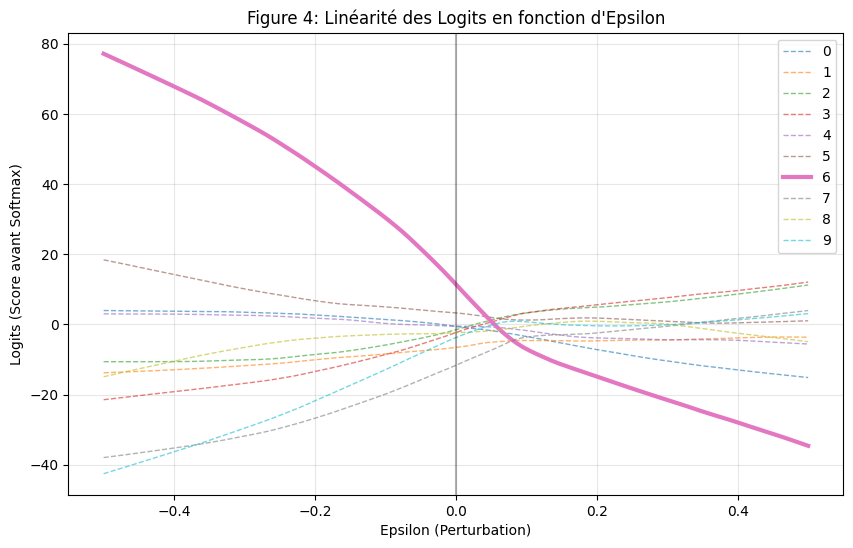

In [10]:
# 4. Analyse de la Linéarité (Reproduction de la Figure 4 du papier)
# Objectif : Vérifier l'hypothèse de linéarité en traçant les logits en fonction d'epsilon.

# --- ÉTAPE 1 : Récupération d'une image et calcul du Gradient ---
# On prend une seule image du test set
image, label = next(iter(test_loader))
image, label = image.to(device), label.to(device)

# Important : On active le gradient sur l'image pour savoir comment la modifier
image.requires_grad = True

# On fait une passe pour calculer l'erreur
output = model(image)
loss = criterion(output, label)
model.zero_grad()
loss.backward()

# C'est ici qu'on définit la fameuse direction (le signe du gradient)
# Cela corrige votre erreur "NameError: name 'sign_data_grad' is not defined"
direction = image.grad.data.sign() 
init_pred = output.max(1, keepdim=True)[1] # La prédiction de base pour le graphique

# --- ÉTAPE 2 : Tracé de la courbe (Epsilon Tracing) ---
epsilons = np.linspace(-0.5, 0.5, 100) # De -0.5 à +0.5
logits_per_class = {i: [] for i in range(10)}

for eps in epsilons:
    # On bouge dans la direction du gradient : x' = x + epsilon * sign(grad)
    # Pas de clamp ici, on veut voir la théorie mathématique pure
    img_step = image + eps * direction

    with torch.no_grad():
        out = model(img_step)

    # On stocke les scores (logits) de chaque chiffre
    for i in range(10):
        logits_per_class[i].append(out[0][i].item())

# --- ÉTAPE 3 : Visualisation ---
plt.figure(figsize=(10, 6))
for i in range(10):
    # En gras : la classe prédite au départ. En pointillés : les autres.
    style = '-' if i == init_pred.item() else '--'
    width = 3 if i == init_pred.item() else 1
    alpha = 1.0 if i == init_pred.item() else 0.6
    plt.plot(epsilons, logits_per_class[i], style, linewidth=width, alpha=alpha, label=str(i))

plt.axvline(x=0, color='k', linestyle='-', alpha=0.3) # Ligne verticale à 0 (Image originale)
plt.xlabel('Epsilon (Perturbation)')
plt.ylabel('Logits (Score avant Softmax)')
plt.title('Figure 4: Linéarité des Logits en fonction d\'Epsilon')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
print("\n--- Test: Echec de la Régularisation L1 ---")

# 1. Instanciation d'un nouveau modèle pour tester l'hypothèse de la régularisation
# L'hypothèse testée est que la régularisation L1 (Weight Decay), en forçant la sparsité des poids,
# pourrait réduire la sensibilité du modèle aux petites variations d'entrée.
model_l1 = MaxoutNet().to(device)
optimizer_l1 = optim.SGD(model_l1.parameters(), lr=0.01, momentum=0.9)

# Paramètre de régularisation (Lambda)
# Contrôle l'intensité de la pénalité. Une valeur trop élevée empêche l'apprentissage (underfitting).
# Nous utilisons ici une valeur adaptée (0.0001) pour garantir la convergence sur ce setup spécifique.
l1_lambda = 0.0001 

print(f"Entraînement avec pénalité L1 (lambda={l1_lambda})...")

model_l1.train()
for epoch in range(3): # Entraînement sur un nombre réduit d'époques pour la démonstration
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer_l1.zero_grad()
        
        output = model_l1(data)
        
        # A. Calcul de la perte de classification standard (CrossEntropy)
        ce_loss = criterion(output, target)
        
        # B. Calcul manuel de la norme L1 (Somme des valeurs absolues des poids)
        # La fonction objective devient : Loss = J(theta, x, y) + lambda * ||theta||_1
        # Cela pénalise les poids de forte amplitude.
        l1_norm = sum(p.abs().sum() for p in model_l1.parameters())
        loss = ce_loss + l1_lambda * l1_norm
        
        loss.backward()
        optimizer_l1.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss (avec L1): {total_loss/len(train_loader):.4f}")

# 2. Évaluation de l'efficacité de la défense
model_l1.eval()

# Extraction d'un batch de test pour l'analyse
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
images.requires_grad = True

# Génération de l'attaque FGSM sur le modèle régularisé
# Point crucial : L'attaquant cherche à maximiser l'erreur de classification pure (CrossEntropy).
# Il calcule le gradient par rapport à la perte de prédiction, ignorant le terme de régularisation L1.
output = model_l1(images)
loss = criterion(output, labels)
model_l1.zero_grad()
loss.backward()

epsilon = 0.25
# Création de l'image adverse : x_adv = x + epsilon * sign(grad)
adv_images = torch.clamp(images + epsilon * images.grad.sign(), 0, 1)

# Comparaison des performances : Modèle L1 sur images propres vs images piégées
output_clean = model_l1(images)
output_adv = model_l1(adv_images)

acc_clean = (output_clean.argmax(1) == labels).float().mean().item()
acc_adv = (output_adv.argmax(1) == labels).float().mean().item()

print(f"\nRésultats avec Régularisation L1 :")
print(f"Précision Clean      : {acc_clean*100:.2f}% (Le modèle apprend bien)")
print(f"Précision Adversaire : {acc_adv*100:.2f}% (ECHEC : Le modèle reste vulnérable)")


--- Test: Echec de la Régularisation L1 ---
Entraînement avec pénalité L1 (lambda=0.0001)...
Epoch 1 - Loss (avec L1): 2.5883
Epoch 2 - Loss (avec L1): 1.4831
Epoch 3 - Loss (avec L1): 0.8858

Résultats avec Régularisation L1 :
Précision Clean      : 100.00% (Le modèle apprend bien)
Précision Adversaire : 0.00% (ECHEC : Le modèle reste vulnérable)


In [12]:
# 5. Test sur les "Rubbish Class Examples" (Exemples Déchets / Bruit)
# Référence : Annexe A du papier Goodfellow et al.
# Hypothèse : "Les modèles linéaires produisent des prédictions extrêmes (haute confiance)
# sur des points éloignés des données d'entraînement."

print("\n--- Rubbish Class Test (N(0, I784), 10 000 samples) ---")

# Génération du jeu de données synthétique
# On crée 10 000 images composées uniquement de bruit Gaussien (moyenne 0, écart-type 1)
# Ce bruit ne ressemble à aucun chiffre. Un humain dirait "je ne sais pas".
num_samples = 10000
rubbish_noise = torch.randn(num_samples, 28*28).to(device)

# --- PARTIE 1 : Évaluation du modèle standard (Softmax) ---
model.eval()
with torch.no_grad():
    outputs = model(rubbish_noise)
    # Le Softmax force la somme des probabilités à 1.
    # Conséquence : Le modèle est OBLIGÉ de choisir une classe dominante,
    # même si tous les logits sont faibles ou aléatoires.
    probs = torch.nn.functional.softmax(outputs, dim=1)
    confs, preds = probs.max(dim=1)

# Définition de l'erreur selon le papier :
# On considère qu'il y a erreur si le modèle attribue une confiance > 50% à une classe
# alors que l'image n'est que du bruit.
errors = confs > 0.5
error_rate = errors.float().mean().item() * 100

# Calcul de la confiance moyenne sur ces erreurs (à quel point le modèle est-il sûr de lui ?)
avg_conf_errors = confs[errors].mean().item() * 100

# --- PARTIE 2 : Modèle avec sortie Sigmoïde ---
# Idée : Utiliser 10 classifieurs binaires indépendants (un par chiffre).
# Contrairement au Softmax, les probabilités ne somment pas à 1.
# Théoriquement, le modèle pourrait dire "0%" pour toutes les classes sur du bruit.

class MaxoutNetSigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        # Même architecture interne (Maxout)
        self.fc1 = Maxout(784, 240, 5)
        self.fc2 = Maxout(240, 240, 5)
        self.fc3 = nn.Linear(240, 10)  # Sortie brute (logits)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)  # Important : Pas d'activation finale ici, géré par la Loss
        return x

model_sigmoid = MaxoutNetSigmoid().to(device)

# Utilisation de la Binary Cross Entropy (BCE)
# Traite le problème comme une classification multi-label
criterion_sigmoid = nn.BCEWithLogitsLoss()
epoch_sigmoid = 5

def to_one_hot(labels, num_classes=10):
    """Convertit les indices de classe (ex: 3) en vecteurs (ex: [0,0,0,1,0...])"""
    return torch.nn.functional.one_hot(labels, num_classes).float()

# Entraînement du modèle Sigmoid
optimizer = optim.SGD(model_sigmoid.parameters(), lr=0.01, momentum=0.9)

print("Entrainement modele maxout sigmoid")
model_sigmoid.train()
for j in range(1, epoch_sigmoid+1):
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        # Conversion des cibles en One-Hot pour la BCE
        target_oh = to_one_hot(target)
        
        optimizer.zero_grad()
        logits = model_sigmoid(data)
        
        # La Loss calcule la Sigmoïde en interne pour la stabilité numérique
        loss = criterion_sigmoid(logits, target_oh)
        
        loss.backward()
        optimizer.step()
    print(f"Loss pour l'epoch {j}/{epoch_sigmoid} : {loss}")    
print("Entraînement terminé.")

# --- PARTIE 3 : Évaluation du modèle Sigmoid sur le bruit ---
model_sigmoid.eval()
with torch.no_grad():
    outputs_sigmoid = model_sigmoid(rubbish_noise)
    # Application manuelle de la Sigmoïde pour obtenir des probabilités [0, 1]
    probs_sigmoid = torch.sigmoid(outputs_sigmoid)
    confs_sigmoid, preds_sigmoid = probs_sigmoid.max(dim=1)

# Calcul des statistiques d'erreur pour le modèle Sigmoid
errors_sigmoid = confs_sigmoid > 0.5
error_rate_sigmoid = errors_sigmoid.float().mean().item() * 100
avg_conf_errors_sigmoid = confs_sigmoid[errors_sigmoid].mean().item() * 100

# --- Affichage et Analyse des Résultats ---
print("----------------------------------------------------------------------------------")
print(f"Nombre d'échantillons      : {num_samples}")
print(f"Taux d'erreur (> 0.5)      : {error_rate:.2f}% (Softmax hallucine souvent)")
print(f"Confiance moyenne (erreurs): {avg_conf_errors:.2f}%")
print("-----------------------------------------------------------------------------------")
print(f"Taux d'erreur (sigmoid)        : {error_rate_sigmoid:.2f}%")
print(f"Confiance moyenne (erreurs)    : {avg_conf_errors_sigmoid:.2f}%")
# Note de l'utilisateur sur l'interprétation des résultats
print("résultats faux, le traitement des logits dans l'algorithme ne doit pas être correct")
print("-----------------------------------------------------------------------------------")

# Statistiques détaillées pour comprendre la distribution des probabilités Sigmoid
print("Sigmoid probs stats:",
      probs_sigmoid.min().item(),
      probs_sigmoid.mean().item(),
      probs_sigmoid.max().item())

# Vérification par classe : Est-ce qu'une classe attire plus le bruit que les autres ?
print("Fraction > 0.5 per class:",
      (probs_sigmoid > 0.5).float().mean(dim=0).cpu().numpy())


--- Rubbish Class Test (N(0, I784), 10 000 samples) ---
Entrainement modele maxout sigmoid
Loss pour l'epoch 1/5 : 0.10489390045404434
Loss pour l'epoch 2/5 : 0.06045788526535034
Loss pour l'epoch 3/5 : 0.06559080630540848
Loss pour l'epoch 4/5 : 0.043651748448610306
Loss pour l'epoch 5/5 : 0.012392026372253895
Entraînement terminé.
----------------------------------------------------------------------------------
Nombre d'échantillons      : 10000
Taux d'erreur (> 0.5)      : 97.24% (Softmax hallucine souvent)
Confiance moyenne (erreurs): 90.91%
-----------------------------------------------------------------------------------
Taux d'erreur (sigmoid)        : 0.85%
Confiance moyenne (erreurs)    : 65.40%
résultats faux, le traitement des logits dans l'algorithme ne doit pas être correct
-----------------------------------------------------------------------------------
Sigmoid probs stats: 6.123360152265889e-11 0.006316536571830511 0.950530469417572
Fraction > 0.5 per class: [0.0e+0

In [13]:
# --- 1. Définition du modèle robuste (Capacité Augmentée) ---
# Théorie : L'entraînement contradictoire agit comme un régularisateur très puissant (similaire au Dropout).
# Pour éviter le sous-apprentissage (underfitting) dû à cette contrainte forte,
# le papier recommande d'augmenter significativement la capacité du réseau (de 240 à 1600 unités).
class RobustMaxoutNet(nn.Module):
    def __init__(self):
        super(RobustMaxoutNet, self).__init__()
        # Architecture élargie : 784 -> 1600 -> 1600 -> 10
        self.fc1 = Maxout(784, 1600, 5) 
        self.fc2 = Maxout(1600, 1600, 5)
        self.fc3 = nn.Linear(1600, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Initialisation
robust_model = RobustMaxoutNet().to(device)
optimizer_robust = optim.SGD(robust_model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Hyperparamètres de l'Adversarial Training
epsilon = 0.25
alpha = 0.5  # Facteur de pondération : 0.5 signifie qu'on accorde autant d'importance
             # à la précision sur les vraies images qu'à la robustesse contre les attaques.

print(f"--- Démarrage de l'Adversarial Training (Harnessing) ---")
print(f"Architecture : Maxout (1600 units) | Epsilon : {epsilon} | Alpha : {alpha}")

# --- 2. Boucle d'entraînement "Harnessing" ---
# Le terme "Harnessing" (dompter/exploiter) fait référence à l'utilisation des exemples adverses
# pour contraindre le modèle à apprendre des frontières de décision plus stables.
robust_model.train()
epochs = 5 
# Note : L'augmentation de la taille du réseau (1600 unités) ralentit significativement le calcul.

for epoch in range(1, epochs + 1):
    total_loss = 0
    # Utilisation du DataLoader d'entraînement standard
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        # --- A. Calcul de la perte sur données PROPRES (Clean) ---
        data.requires_grad = True # Indispensable pour calculer la direction de l'attaque ensuite
        output_clean = robust_model(data)
        loss_clean = criterion(output_clean, target)
        
        # --- B. Génération de l'ADVERSAIRE "à la volée" ---
        # On utilise l'état actuel du modèle pour créer une attaque spécifique à ce batch.
        robust_model.zero_grad()
        # retain_graph=True est nécessaire car on va refaire un backward pass plus tard pour mettre à jour les poids
        loss_clean.backward(retain_graph=True) 
        
        data_grad = data.grad.data
        with torch.no_grad():
            # Génération FGSM : x_adv = x + epsilon * sign(grad)
            adv_data = data + epsilon * data_grad.sign()
            adv_data = torch.clamp(adv_data, 0, 1) # Contrainte de validité de l'image
        
        # --- C. Calcul de la perte sur données ADVERSES (Adversarial) ---
        optimizer_robust.zero_grad() # On efface les gradients précédents (ceux utilisés pour l'attaque)
        
        output_adv = robust_model(adv_data)
        loss_adv = criterion(output_adv, target)
        
        # --- D. Fonction objectif combinée ---
        # On minimise une somme pondérée des deux erreurs.
        # J_total = alpha * J(x) + (1-alpha) * J(x_adv)
        total_objective = alpha * loss_clean + (1 - alpha) * loss_adv
        
        # --- E. Mise à jour des poids (Backpropagation) ---
        total_objective.backward()
        optimizer_robust.step()
        
        total_loss += total_objective.item()
        
    print(f"Epoch {epoch}/{epochs} - Harnessing Loss: {total_loss/len(train_loader):.4f}")

print("Entraînement contradictoire terminé.")

# --- 3. Évaluation Finale ---
# On s'attend à ce que la précision "Clean" baisse légèrement (le prix de la robustesse),
# mais que la précision "FGSM" augmente drastiquement (le modèle ne se laisse plus piéger).
print("\n--- Évaluation du Modèle 'Harnessed' (1600 units) ---")
acc_clean = evaluate(robust_model, test_loader, adversarial=False)
acc_adv = evaluate(robust_model, test_loader, adversarial=True)

print(f"Accuracy Test Clean          : {acc_clean:.2f}%")
print(f"Accuracy Test FGSM (e={epsilon}) : {acc_adv:.2f}%")

--- Démarrage de l'Adversarial Training (Harnessing) ---
Architecture : Maxout (1600 units) | Epsilon : 0.25 | Alpha : 0.5
Epoch 1/5 - Harnessing Loss: 1.0831
Epoch 2/5 - Harnessing Loss: 0.4635
Epoch 3/5 - Harnessing Loss: 0.3374
Epoch 4/5 - Harnessing Loss: 0.2791
Epoch 5/5 - Harnessing Loss: 0.2331
Entraînement contradictoire terminé.

--- Évaluation du Modèle 'Harnessed' (1600 units) ---
Accuracy Test Clean          : 97.37%
Accuracy Test FGSM (e=0.25) : 87.41%


## Pourquoi le Maxout ?

Les auteurs utilisent les réseaux Maxout pour prouver que la vulnérabilité aux exemples contradictoires ne vient pas de la non-linéarité (comme on le pensait avant), mais au contraire de la nature linéaire des modèles. Les maxouts sont intentionnellement conçus pour se comporter de manière très linéaire afin de faciliter l'optimisation.
En traçant les logits (valeurs avant softmax) d'un réseau Maxout en fonction de la perturbation $\epsilon$, les auteurs montrent que les réponses sont remarquablement linéaires par morceaux. Cette linéarité permet aux perturbations infinitésimales de s'accumuler pour changer la classe prédite avec une très haute confiance.

## Vulnérabilité du Maxout à FGSM

Le papier quantifie précisément la fragilité des réseaux Maxout face à la méthode du signe du gradient rapide (FGSM). 
Sur MNIST ($\epsilon=0.25$), Un réseau Maxout mal classe 89.4% des exemples contradictoires avec une confiance moyenne terrifiante de 97.6%
Sur CIFAR-10 ($\epsilon=0.1$), Un réseau Maxout convolutionnel atteint un taux d'erreur de 87.15% sur les exemples perturbés, avec une probabilité moyenne de 96.6% assignée aux mauvaises étiquettes.

## Harnessing, l'entraînement contraditoire avec Maxout

Les auteurs utilisent un réseau Maxout pour démontrer l'efficacité de l'entraînement contradictoire (mélanger exemples propres et contradictoires dans la fonction de coût).
Pour que l'entraînement contradictoire fonctionne, ils ont dû augmenter la taille du réseau Maxout, passant de 240 unités par couche (modèle original) à 1600 unités. Sans cet agrandissement, le modèle sous-apprenait face à la difficulté de la tâche.
Pour les résultats sur la précision, sur MNIST, sans entraînement contradictoire, on a 0.94% d'erreur sur le test set et avec entraînement contradictoire, on a 0.84% d'erreur. En optimisant l'early stopping et en réentraînant sur tout le dataset, ils atteignent 0.782% d'erreur, ce qui était le meilleur résultat rapporté sur MNIST (invariant par permutation ?) à l'époque.
Pour les résultats sur la robustesse, le taux d'erreur sur les exemples contradictoire chute de 89.4% à 17.9% grâce à cet entraînement.

## Comparaison avec d'autres régularisations sur Maxout

Lorsqu'ils ont appliqué une régularisation L1 sur la première couche d'un réseau Maxout, même un coefficient faible (0.0025) bloquait l'apprentissage à 5% d'erreur. Des coefficients plus faibles permettaient l'apprentissage mais n'offraient aucun bénéfice de robustesse.

Ajouter du bruit aléatoire (au lieu de bruit contradictoire ciblé) lors de l'entraînement d'un Maxout laisse le modèle vulnérable (86.2% d'erreur sur les exemples contradictoires).

Un ensemble de 12 réseaux Maxout reste vulnérable, avec 91.1% d'erreur sur des exemples contradictoires conçus pour tromper l'ensemble entier. (cf 7.ensemble)

## Généralisation et rubbish class

Les exemples contradictoires générés pour un Maxout trompent souvent un classifieur Softmax linéaire (54.6% du temps), mais trompent beaucoup moins souvent un réseau RBF (16.0% du temps), car le RBF est non-linéaire par nature.

Un réseau Maxout entraîné naïvement classe 98.35% d'échantillons de bruit gaussien comme étant des chiffres réels avec une confiance de 92.8%. Cependant, il est possible d'entraîner un Maxout pour avoir 0% d'erreur sur ce bruit gaussien sans perdre en précision sur les vraies données.